In [103]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np


# # THIS SHIT SLOWS MY COMPUTER
# pd.reset_option('max_colwidth')
# pd.reset_option('max_row')

def load_column_array(cols):
    cols_booleans = [
        "IsBeta",
        "IsSxsPassiveMode",
        "HasTpm",
        "IsProtected",
        "AutoSampleOptIn",
        "PuaMode",
        "SMode",
        "Firewall",
        "UacLuaenable",
        "Census_HasOpticalDiskDrive",
        "Census_IsPortableOperatingSystem",
        "Census_IsFlightingInternal",
        "Census_IsFlightsDisabled",
        "Census_ThresholdOptIn",
        "Census_IsSecureBootEnabled",
        "Census_IsWIMBootEnabled",
        "Census_IsVirtualDevice",
        "Census_IsTouchEnabled",
        "Census_IsPenCapable",
        "Census_IsAlwaysOnAlwaysConnectedCapable",
        "Wdft_IsGamer"
    ]

    cols_categorical = [
        "ProductName",
        "EngineVersion",
        "AppVersion",
        "AvSigVersion_x_x",
        "RtpStateBitfield",
        "AVProductsInstalled",
        "AVProductsEnabled",
        "CountryIdentifier",
        "OrganizationIdentifier",
        "Platform",
        "Processor",
        "OsVer",
        "OsBuild",
        "OsSuite",
        "OsPlatformSubRelease",
        "SkuEdition",
        "SmartScreen",
        "Census_MDC2FormFactor",
        "Census_DeviceFamily",
        "Census_ProcessorManufacturerIdentifier",
        "Census_ProcessorClass",
        "Census_PrimaryDiskTypeName",
        "Census_ChassisTypeName",
        "Census_PowerPlatformRoleName",
        "Census_InternalBatteryType",
        "Census_OSArchitecture",
        "Census_OSBranch",
        "Census_OSBuildNumber",
        "Census_OSEdition",
        "Census_OSSkuName",
        "Census_OSInstallTypeName",
        "Census_OSInstallLanguageIdentifier",
        "Census_OSUILocaleIdentifier",
        "Census_OSWUAutoUpdateOptionsName",
        "Census_GenuineStateName",
        "Census_ActivationChannel",
        "Census_FlightRing",
        "Wdft_RegionIdentifier"
    ]

    cols_categorical_large = [
        "AvSigVersion",
        "DefaultBrowsersIdentifier",
        "AVProductStatesIdentifier",
        "CityIdentifier",
        "GeoNameIdentifier",
        "OsBuildLab",
        "IeVerIdentifier",
        "Census_OEMNameIdentifier",
        "Census_OEMModelIdentifier",
        "Census_ProcessorModelIdentifier",
        "Census_OSVersion",
        "Census_OSBuildRevision",
        "Census_FirmwareManufacturerIdentifier",
        "Census_FirmwareVersionIdentifier",
        "LocaleEnglishNameIdentifier"
    ]

    cols_numerical = [
        "Census_ProcessorCoreCount",
        "Census_PrimaryDiskTotalCapacity",
        "Census_SystemVolumeTotalCapacity",
        "Census_TotalPhysicalRAM",
        "Census_InternalPrimaryDiagonalDisplaySizeInInches",
#         "Census_InternalPrimaryDisplayResolutionHorizontal",
#         "Census_InternalPrimaryDisplayResolutionVertical",
        "Census_InternalBatteryNumberOfCharges",
        "TotalDisplayResolution"
    ]
    
    # Update our column arrays
    cols_categorical = [x for x in cols_categorical if x in cols]
    cols_numerical = [x for x in cols_numerical if x in cols]
    cols_booleans = [x for x in cols_booleans if x in cols]
    cols_categorical_large = [x for x in cols_categorical_large if x in cols]
    
    return cols_categorical, cols_numerical, cols_booleans, cols_categorical_large

def get_one_hot_encodings(df, cols):
    result = pd.DataFrame()
    i = 0
    for col in cols:
        dummies = pd.get_dummies(df[col],prefix=col)
        if( i == 0 ):
            result = dummies.copy()
        else:
            result = pd.concat((result, dummies), axis=1)
        i+=1
    return result

def reduce_features(df, verbose = False):
    # calculate the correlation matrix
    corr_matrix  = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    
    #Get all of the correlation values > 95%
    x = np.where(upper > 0.95)

    #Display all field combinations with > 95% correlation
    cf = pd.DataFrame()
    cf['Field1'] = upper.columns[x[1]]
    cf['Field2'] = upper.index[x[0]]

    #Get the correlation values for every field combination. (There must be a more pythonic way to do this!)
    corr = [0] * len(cf)
    for i in range(0, len(cf)):
        corr[i] =  upper[cf['Field1'][i]][cf['Field2'][i]] 

    cf['Correlation'] = corr

    if( verbose ):
        print('There are ', str(len(cf['Field1'])), ' field correlations > 95%.')
        display(cf)
        
        print('Dropping the following ', str(len(to_drop)), ' highly correlated fields.')
        to_drop
        
    #Check columns before drop 
    if( verbose ):
        print('\r\n*********Before: Dropping Highly Correlated Fields*************************************')
        display(df.info(verbose=False))

    # Drop the highly correlated features from our training data 
    df = df.drop(to_drop, axis=1)

    #Check columns after drop 
    if( verbose ):
        print('\r\n*********After: Dropping Highly Correlated Fields**************************************')
        df.info(verbose=False)
    
    return df

In [106]:
%%time 

# Load Data
import pandas as pd
import numpy as np

# Get data and create a model
malware = pd.read_csv("data/malware.clean.csv")

#New Feature
malware["TotalDisplayResolution"] = malware.Census_InternalPrimaryDisplayResolutionHorizontal * malware.Census_InternalPrimaryDisplayResolutionVertical

#Log values to remove outliers
malware["Census_SystemVolumeTotalCapacity"] = np.log(malware.Census_SystemVolumeTotalCapacity)
malware["Census_TotalPhysicalRAM"] = np.log(malware.Census_TotalPhysicalRAM)
malware["Census_PrimaryDiskTotalCapacity"] = np.log(malware.Census_PrimaryDiskTotalCapacity)

#Get all categories or cast
cols_categorical, cols_numerical, cols_booleans, cols_categorical_large = load_column_array(malware.columns)
malware[cols_categorical] = malware[cols_categorical].astype(object)
malware[cols_categorical_large] = malware[cols_categorical_large].astype(object)

# Shrink Data and Create Datasets in order to Run Basic Models 
model_data = pd.concat(
    (    
        malware[cols_booleans],
        malware[cols_numerical],
        get_one_hot_encodings(malware, cols_categorical)
    ), axis = 1)

print(model_data.shape)

(332912, 486)
CPU times: user 24.9 s, sys: 4.48 s, total: 29.4 s
Wall time: 7.8 s


Reduce Features

In [107]:
%%time 
model_data = reduce_features(model_data, verbose=True)

model_data.to_csv("data/model_data.csv",index=False)

There are  2  field correlations > 95%.


Field1                     Field2  Correlation
0  Census_OSBranch_th2_release_sec  AppVersion_4.9.10586.1106     1.000000
1      Census_OSBranch_rs1_release              OsBuild_14393     0.962024

Dropping the following  2  highly correlated fields.

*********Before: Dropping Highly Correlated Fields*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Columns: 365 entries, level_0 to Census_ActivationChannel_Volume:MAK
dtypes: float64(7), int64(358)
memory usage: 379.3 KB


None


*********After: Dropping Highly Correlated Fields**************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Columns: 363 entries, level_0 to Census_ActivationChannel_Volume:MAK
dtypes: float64(7), int64(356)
memory usage: 377.3 KB
CPU times: user 854 ms, sys: 7.53 ms, total: 861 ms
Wall time: 304 ms


Sample data

In [97]:
import numpy as np
import pandas as pd

model_data = pd.read_csv("data/model_data.csv")

malware = pd.read_csv("data/malware.clean.csv")
response_data = malware["HasDetections"]

sample_size = .02
model_data = model_data.sample(frac=sample_size, replace=True, random_state=42)
response_data = response_data.sample(frac=sample_size, replace=True, random_state=42)

model_data = model_data.reset_index()
response_data = response_data.reset_index()

del model_data['index']
del response_data['index']

print(response_data.shape)
print(model_data.shape)

(6658, 1)
(133, 365)


PCA
* Use MinMaxScaller

In [32]:
pd.set_option('max_colwidth', model_data.shape[1])
from sklearn.preprocessing import MinMaxScaler

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Scale Data
X = MinMaxScaler().fit_transform(model_data)


df = pd.DataFrame(X, columns=model_data.columns.values)
display(df.describe())

pd.reset_option('max_colwidth')

Census_IsSecureBootEnabled  Wdft_IsGamer  Census_ProcessorCoreCount  \
count                 6658.000000   6658.000000                6658.000000   
mean                     0.575398      0.204416                   0.056581   
std                      0.494320      0.403304                   0.043105   
min                      0.000000      0.000000                   0.000000   
25%                      0.000000      0.000000                   0.025641   
50%                      1.000000      0.000000                   0.076923   
75%                      1.000000      0.000000                   0.076923   
max                      1.000000      1.000000                   1.000000   

       Census_PrimaryDiskTotalCapacity  Census_TotalPhysicalRAM  \
count                      6658.000000              6658.000000   
mean                          0.687483                 0.354634   
std                           0.193429                 0.136309   
min                           0.000000                 0.000000   
25%                           0.622857                 0.333490   
50%                           0.714701                 0.333490   
75%                           0.857350                 0.500117   
max                           1.000000                 1.000000   

       Census_InternalPrimaryDiagonalDisplaySizeInInches  \
count                                        6658.000000   
mean                                            0.067904   
std                                             0.038131   
min                                             0.000000   
25%                                             0.053215   
50%                                             0.065041   
75%                                             0.065780   
max                                             1.000000   

       Census_InternalBatteryNumberOfCharges  TotalDisplayResolution  \
count                            6658.000000             6658.000000   
mean                                0.252779                0.105775   
std                                 0.434638                0.055417   
min                                 0.000000                0.000000   
25%                                 0.000000                0.086871   
50%                                 0.000000                0.086871   
75%                                 1.000000                0.086871   
max                                 1.000000                1.000000   

       EngineVersion_1.1.11701.0  EngineVersion_1.1.11903.0  ...  \
count                     6658.0                     6658.0  ...   
mean                         0.0                        0.0  ...   
std                          0.0                        0.0  ...   
min                          0.0                        0.0  ...   
25%                          0.0                        0.0  ...   
50%                          0.0                        0.0  ...   
75%                          0.0                        0.0  ...   
max                          0.0                        0.0  ...   

       Census_OSWUAutoUpdateOptionsName_DownloadNotify  \
count                                      6658.000000   
mean                                          0.001502   
std                                           0.038729   
min                                           0.000000   
25%                                           0.000000   
50%                                           0.000000   
75%                                           0.000000   
max                                           1.000000   

       Census_OSWUAutoUpdateOptionsName_FullAuto  \
count                                6658.000000   
mean                                    0.344998   
std                                     0.475403   
min                                     0.000000   
25%                                     0.000000   
50%                                     0.000000   
75%       

40% of variance explained by 5 principal conponents
60% of variance explained by 12 principal conponents
80% of variance explained by 24 principal conponents
95% of variance explained by 54 principal conponents
99% of variance explained by 100 principal conponents


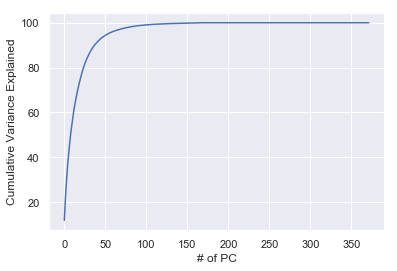

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=X.shape[1])
X_pca = pca.fit_transform(X)

# pca_expl_var = pca.explained_variance_ratio_
pca_sum = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4 ) * 100 )
plt.plot(pca_sum)
plt.xlabel('# of PC')
plt.ylabel('Cumulative Variance Explained')

print( "40% of variance explained by {0} principal conponents".format(sum(pca_sum <= 40)) )
print( "60% of variance explained by {0} principal conponents".format(sum(pca_sum <= 60)) )
print( "80% of variance explained by {0} principal conponents".format(sum(pca_sum <= 80)) )
print( "95% of variance explained by {0} principal conponents".format(sum(pca_sum <= 95)) )
print( "99% of variance explained by {0} principal conponents".format(sum(pca_sum <= 99)) )

How well does PCA work compared to HasDetections?
* Plot the first 4 PCA

In [35]:
# prep data
df = pd.DataFrame(X_pca[:,:10])
df.columns = ['PC1','PC2', 'PC3', 'PC4','PC5', 'PC6','PC7', 'PC8','PC9','PC10']
df['HasDetections'] = response_data.values

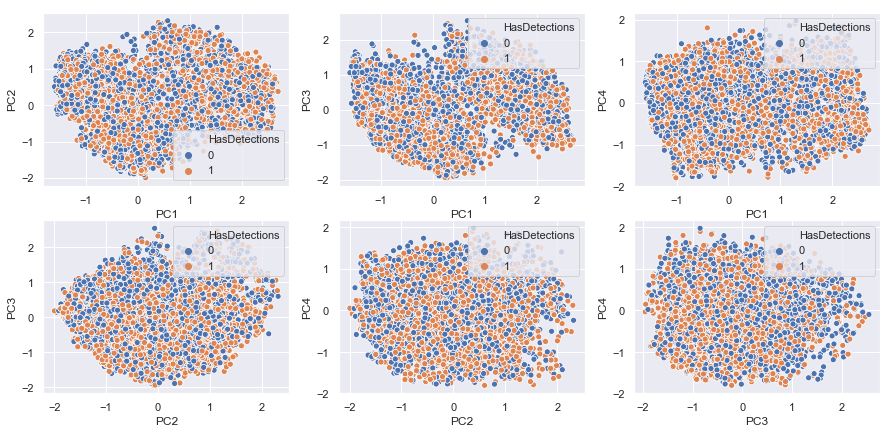

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax =plt.subplots(2,3,figsize=(15,7))
pc1_pc2 = sns.scatterplot(x="PC1", y="PC2", hue="HasDetections", data=df, ax=ax[0,0])
pc1_pc3 = sns.scatterplot(x="PC1", y="PC3", hue="HasDetections", data=df, ax=ax[0,1])
pc1_pc4 = sns.scatterplot(x="PC1", y="PC4", hue="HasDetections", data=df, ax=ax[0,2])
pc2_pc3 = sns.scatterplot(x="PC2", y="PC3", hue="HasDetections", data=df, ax=ax[1,0])
pc2_pc4 = sns.scatterplot(x="PC2", y="PC4", hue="HasDetections", data=df, ax=ax[1,1])
pc3_pc4 = sns.scatterplot(x="PC3", y="PC4", hue="HasDetections", data=df, ax=ax[1,2])

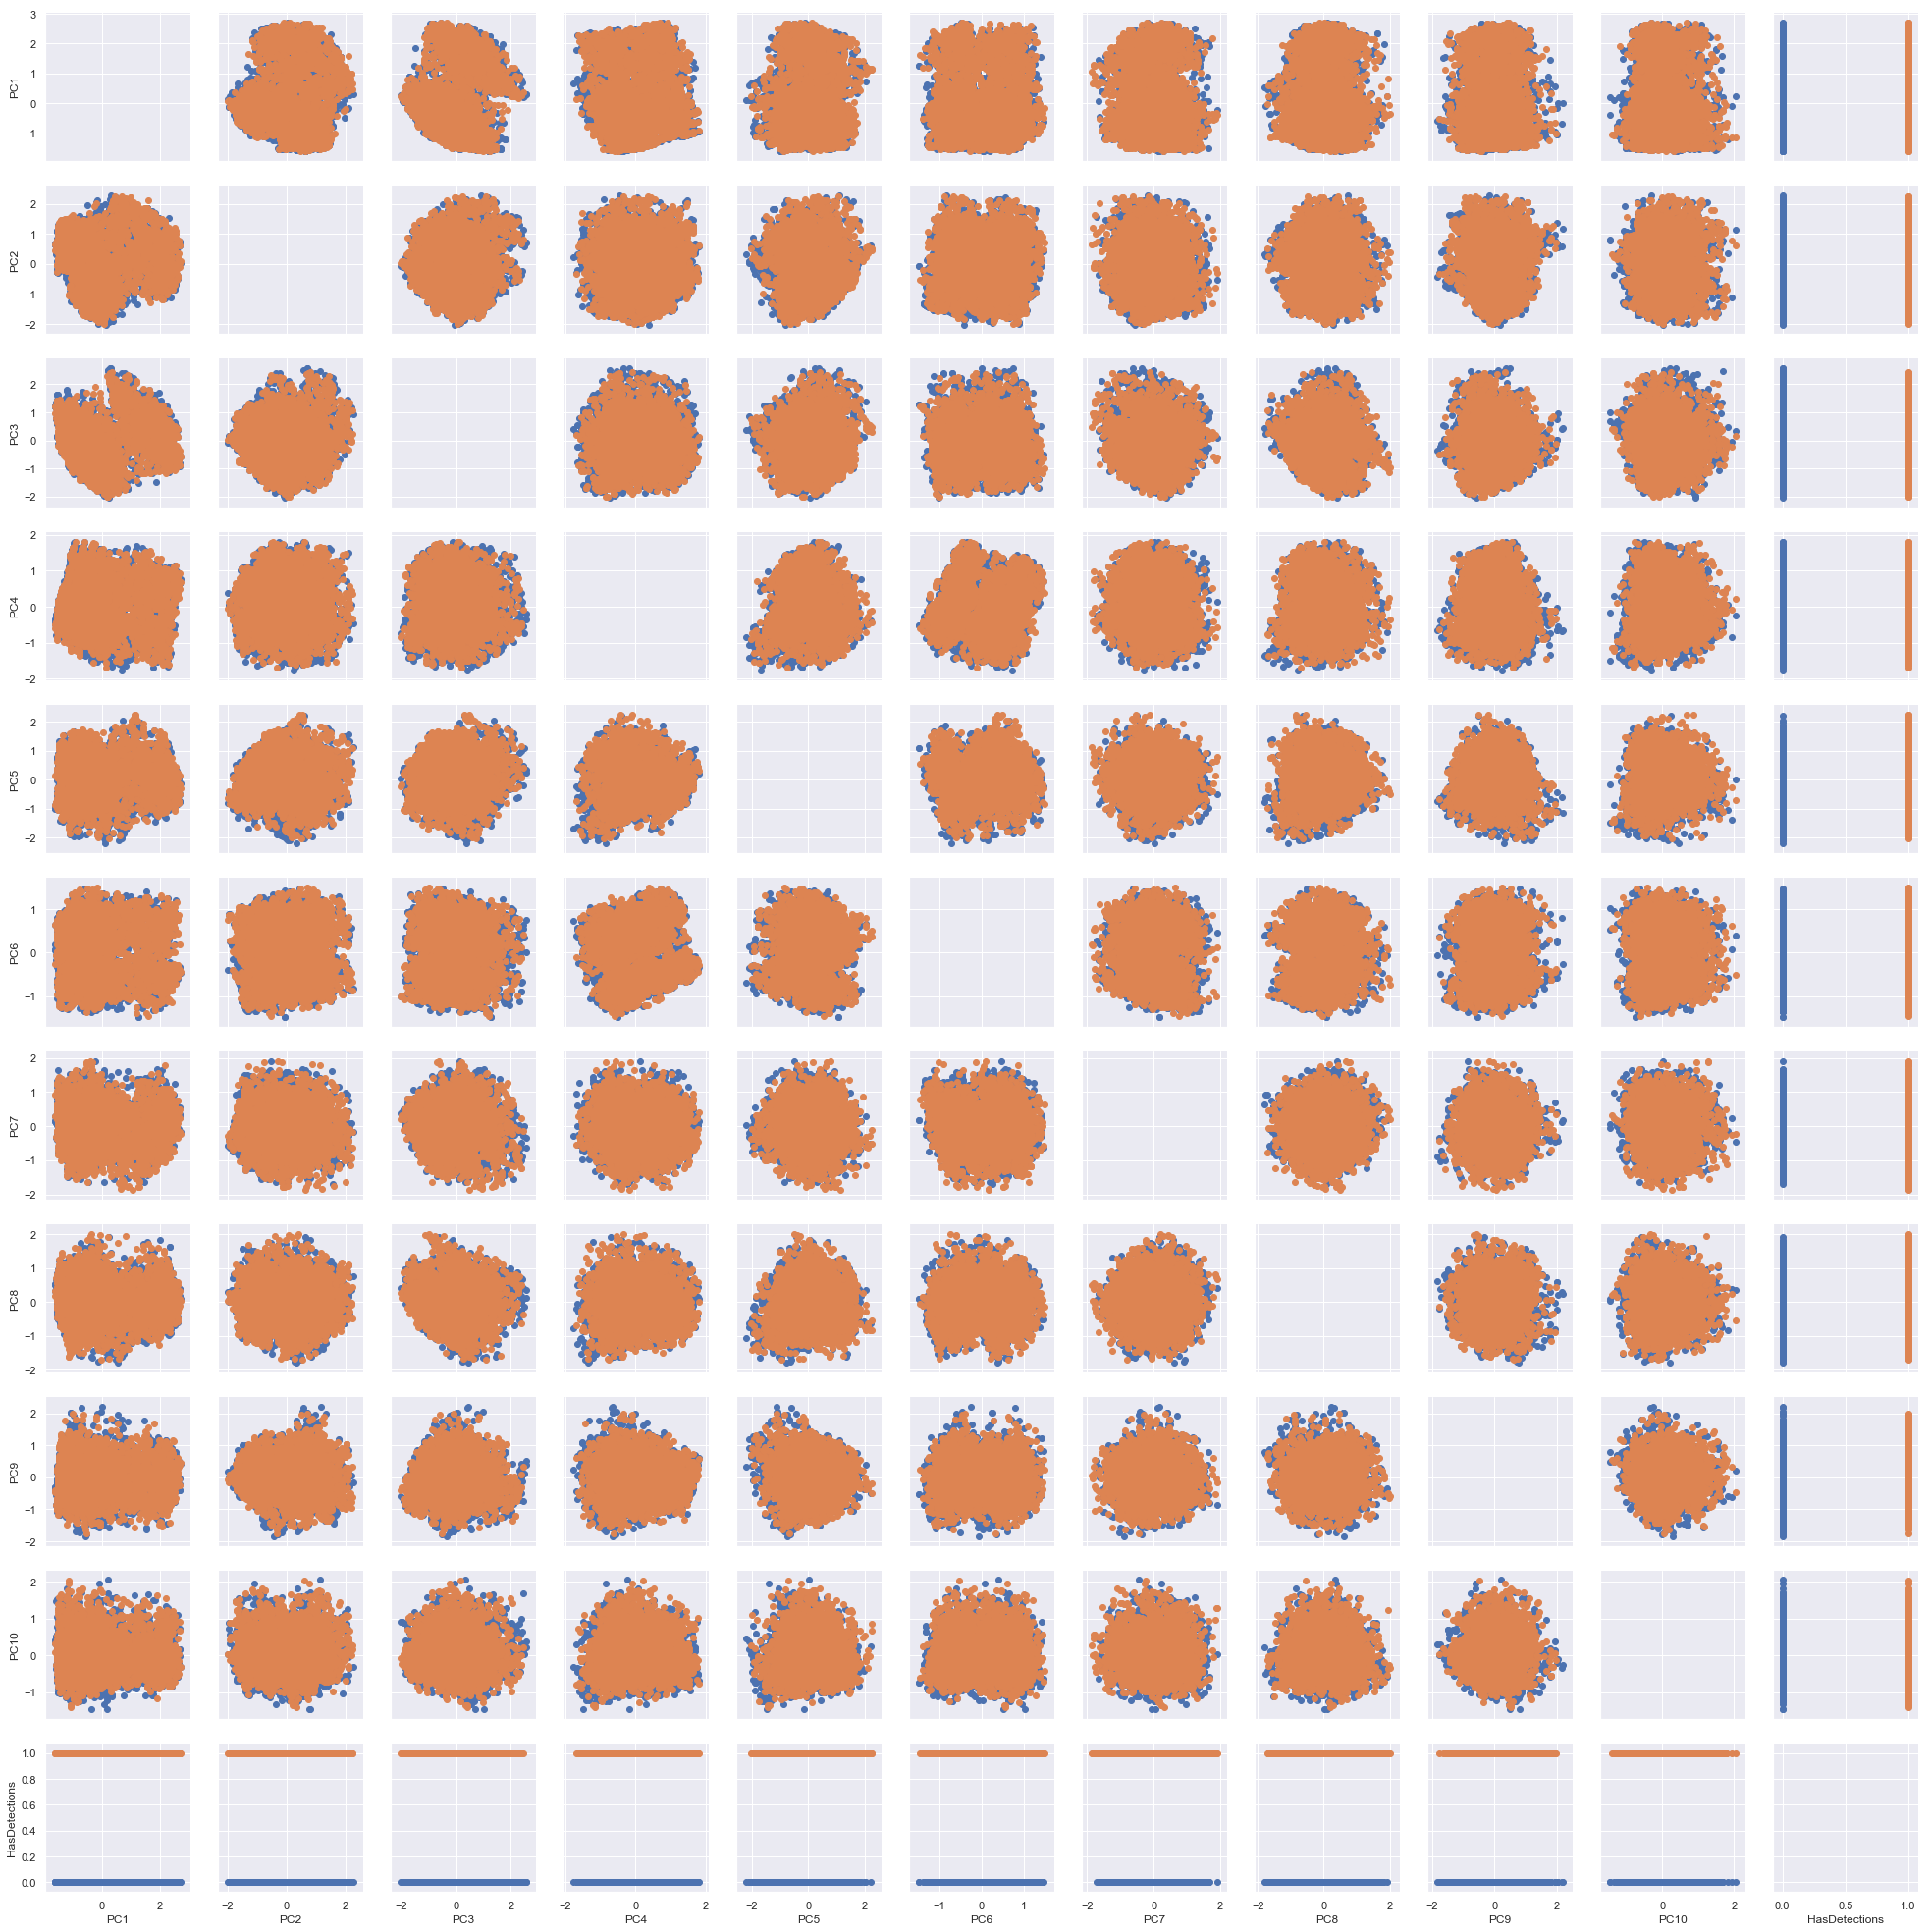

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

df = pd.DataFrame(X_pca[:,:10])
df.columns = ['PC1','PC2', 'PC3', 'PC4','PC5', 'PC6','PC7', 'PC8','PC9','PC10']
df['HasDetections'] = HasDetections_response_data.values
g = sns.PairGrid(df,hue='HasDetections')
g = g.map_offdiag(plt.scatter)
# g = g.map_diag(plt.hist)

Let's cluster the data using KMeans

In [38]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

c = sum(pca_sum <= 80)
print("Cluster on the first {0} features from the PCA Analysis".format(c))
X = X_pca[:,:c]
X = StandardScaler().fit_transform(X)

optimal_silhouette_avg = 0

s = int(len(X_pca) * .2)
print("Using a sample size of ", s, "in order to calculat the Silhouette Score.")

for k in [2, 3, 4, 5, 10, 15, 20, 30, 50, 100]:
    kMeans_cls = KMeans(n_clusters=k, init='k-means++',random_state=42, n_jobs=-2)
    cluster_labels = kMeans_cls.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=s, random_state=42)
    print("For n_clusters = %d, the average silhouette_score is %f, and SSE Distance is %f."
          % (k, silhouette_avg, kMeans_cls.inertia_))

Cluster on the first 24 features from the PCA Analysis
Using a sample size of  1331 in order to calculat the Silhouette Score.
For n_clusters = 2, the average silhouette_score is 0.041341, and SSE Distance is 153390.053450.
For n_clusters = 3, the average silhouette_score is 0.064821, and SSE Distance is 146876.614182.
For n_clusters = 4, the average silhouette_score is 0.082416, and SSE Distance is 140470.142272.
For n_clusters = 5, the average silhouette_score is 0.085876, and SSE Distance is 134734.156336.
For n_clusters = 10, the average silhouette_score is 0.081110, and SSE Distance is 119459.516233.
For n_clusters = 15, the average silhouette_score is 0.061626, and SSE Distance is 112353.375882.
For n_clusters = 20, the average silhouette_score is 0.068439, and SSE Distance is 106992.722332.
For n_clusters = 30, the average silhouette_score is 0.063620, and SSE Distance is 100217.715123.
For n_clusters = 50, the average silhouette_score is 0.061950, and SSE Distance is 91292.7479

Visualize the Elbow Chart

Cluster on the first 24 features from the PCA Analysis


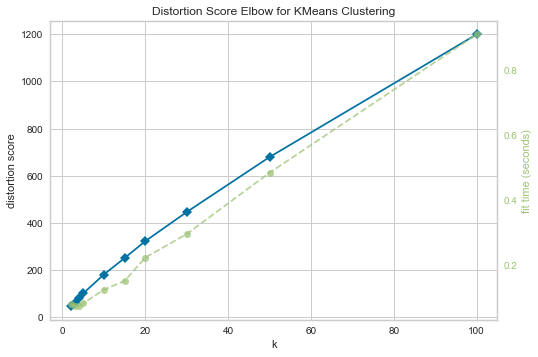

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

c = sum(pca_sum <= 80)
print("Cluster on the first {0} features from the PCA Analysis".format(c))
X = X_pca[:,:c]
X = StandardScaler().fit_transform(X)

cls = KMeans(init='k-means++',random_state=42, n_jobs=-2)
visualizerKmeans = KElbowVisualizer(
    model=cls, 
    metrics="distortion",
    k=(2, 3, 4, 5, 10, 15, 20, 30, 50, 100)
)
visualizerKmeans.fit(X)    # Fit the data to the visualizer
visualizerKmeans.poof()    # Draw/show/poof the data

Visualize the Silhouette

Cluster on the first 24 features from the PCA Analysis


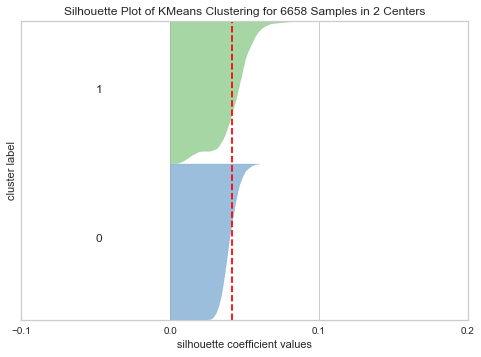

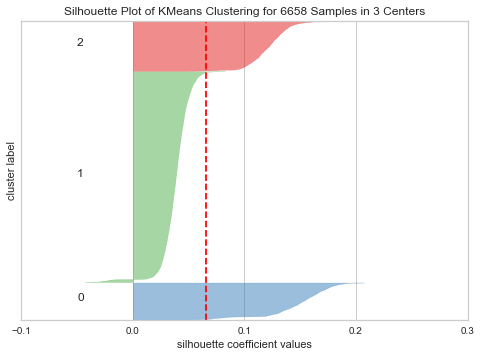

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

c = sum(pca_sum <= 80)
print("Cluster on the first {0} features from the PCA Analysis".format(c))
X = X_pca[:,:c]
X = StandardScaler().fit_transform(X)

cls = KMeans(n_clusters=2, init='k-means++',random_state=42, n_jobs=-2)
visualizerSilhouette = SilhouetteVisualizer(cls)
visualizerSilhouette.fit(X)    # Fit the data to the visualizer
visualizerSilhouette.poof()    # Draw/show/poof the data

cluster2 = cls.fit_predict(X)

cls = KMeans(n_clusters=3, init='k-means++',random_state=42, n_jobs=-2)
visualizerSilhouette = SilhouetteVisualizer(cls)
visualizerSilhouette.fit(X)    # Fit the data to the visualizer
visualizerSilhouette.poof()    # Draw/show/poof the data

cluster3 = cls.fit_predict(X)


Set PCA to 10 Variables  
Plot to see relatinship between each Variable

In [50]:
#Append to Datafram

df["kcluster2"] = cluster2
df["kcluster3"] = cluster3

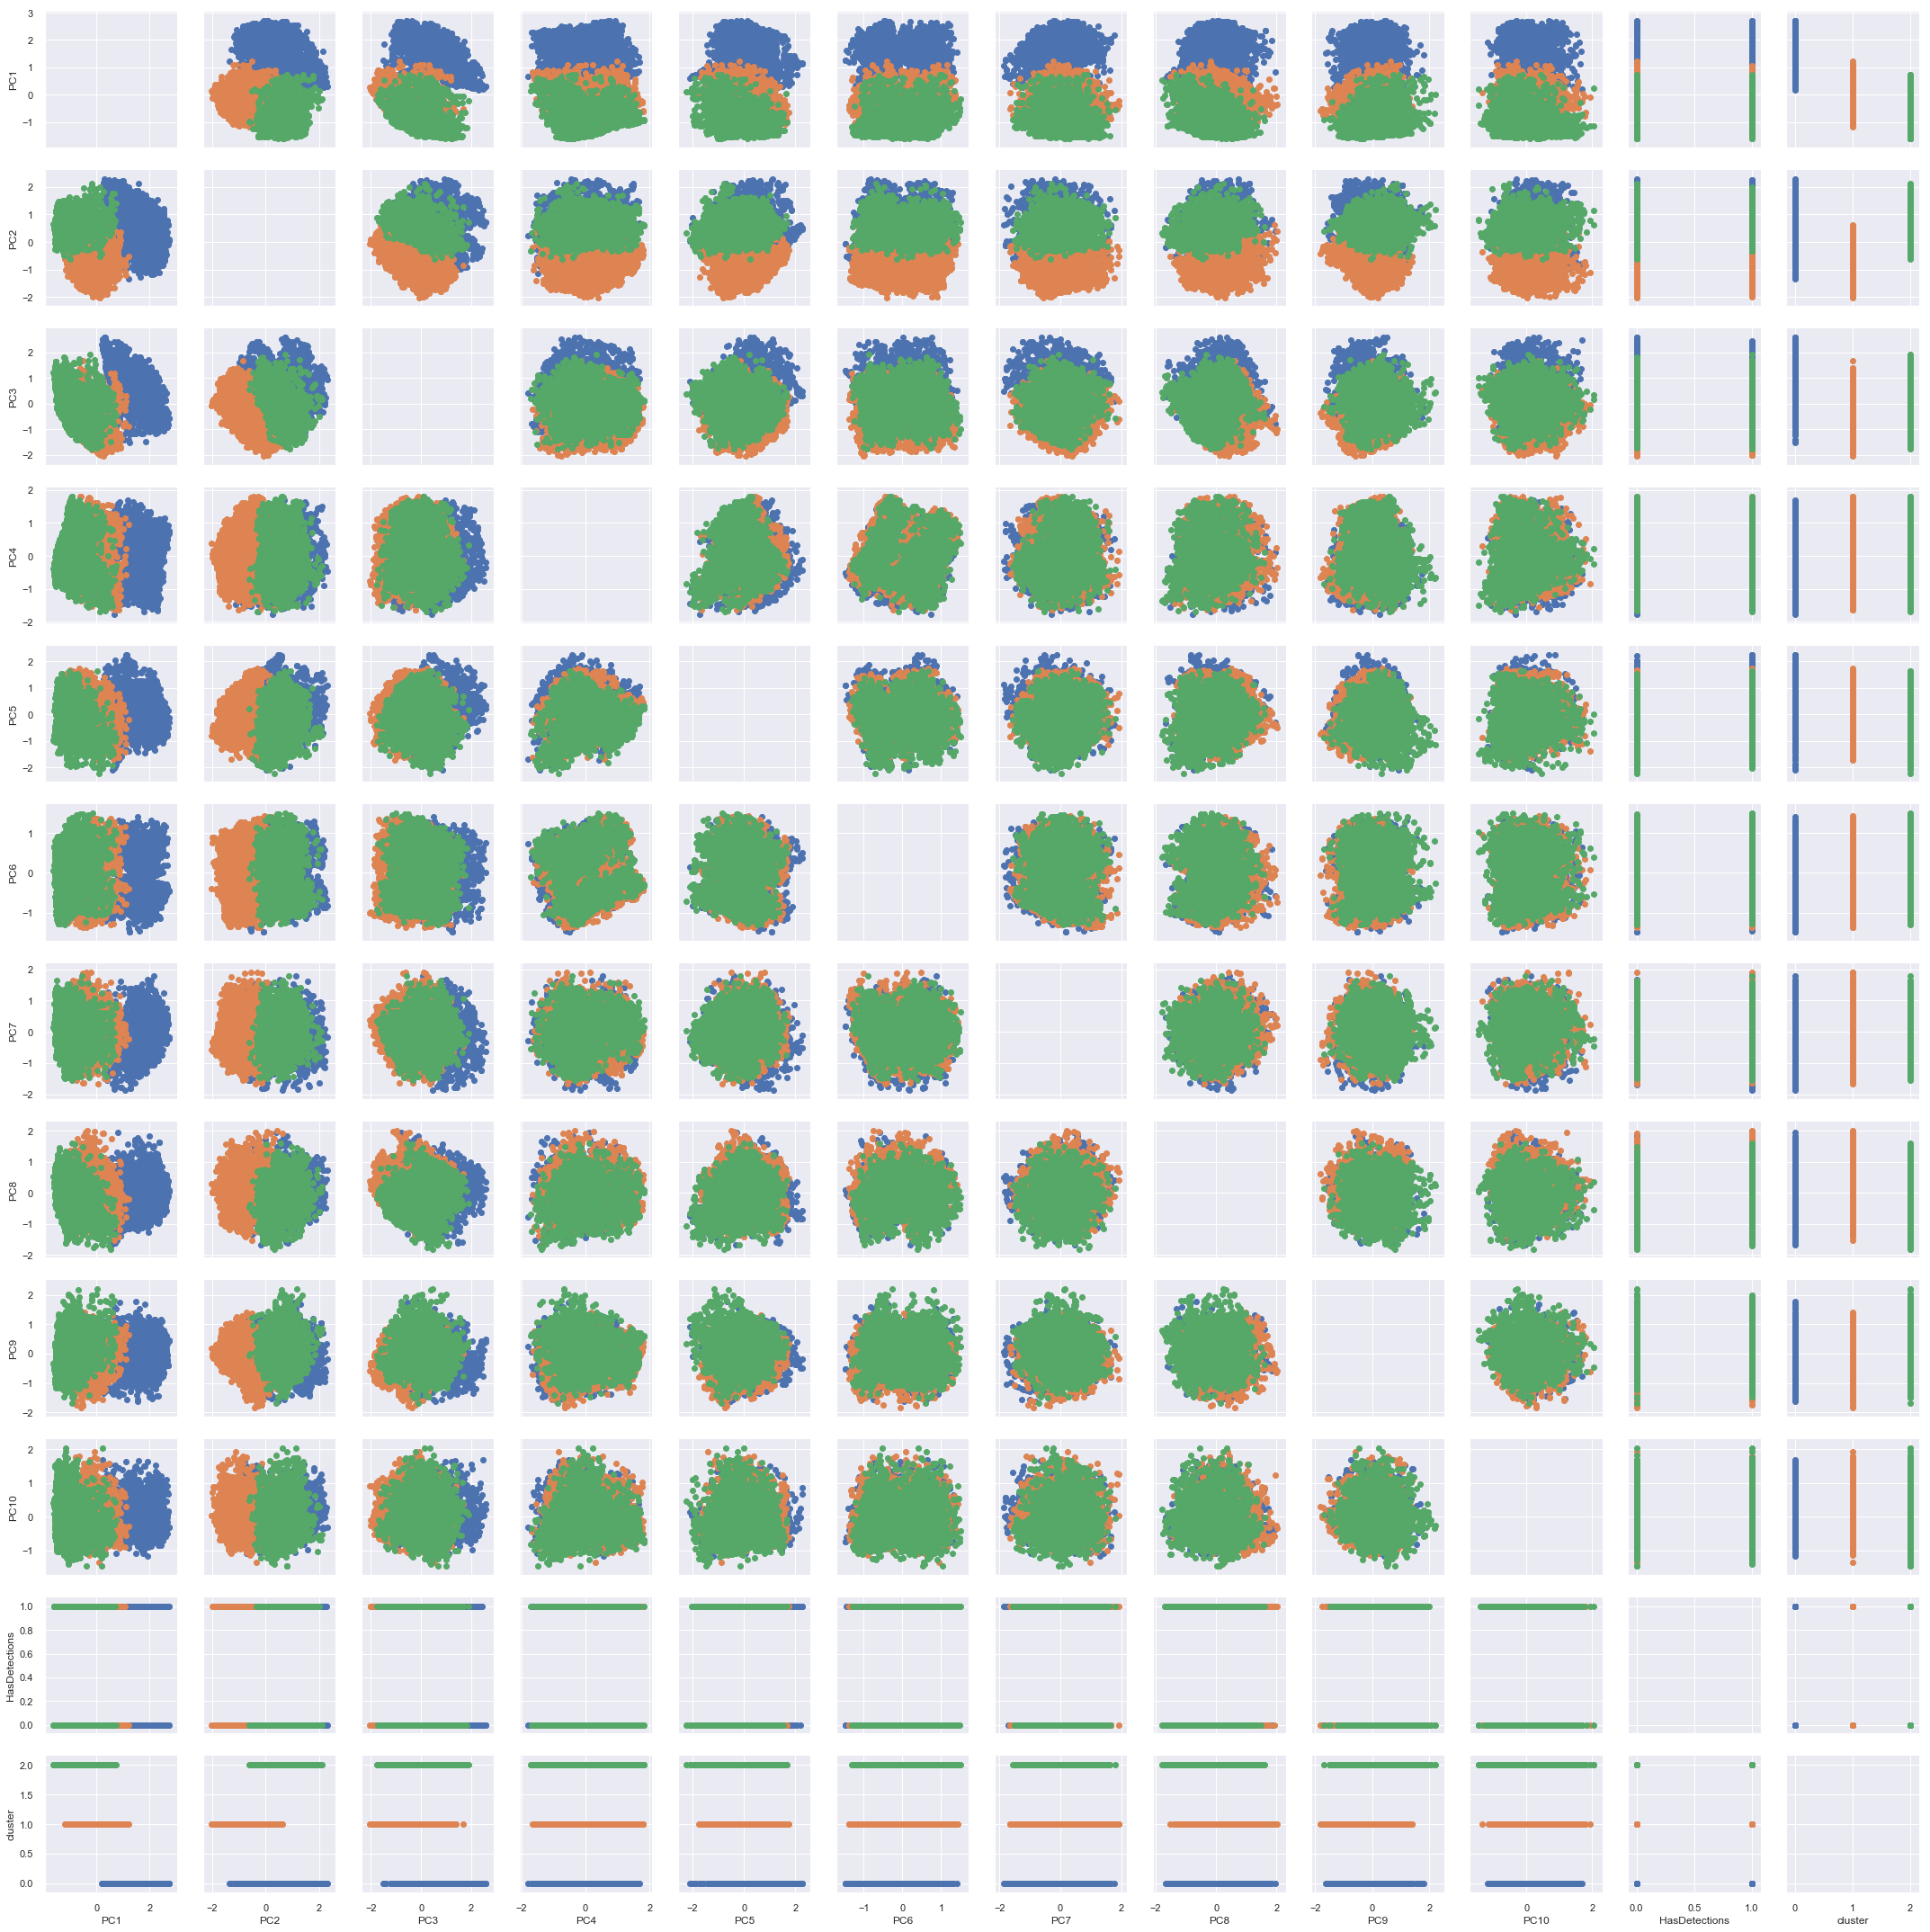

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
                      
# Not working
g = sns.PairGrid(df,hue="cluster")
g = g.map_offdiag(plt.scatter)
# g = g.map_diag(plt.hist)

Compare PC1 and PC2 using the Cluster Catagory to understand the centernoids

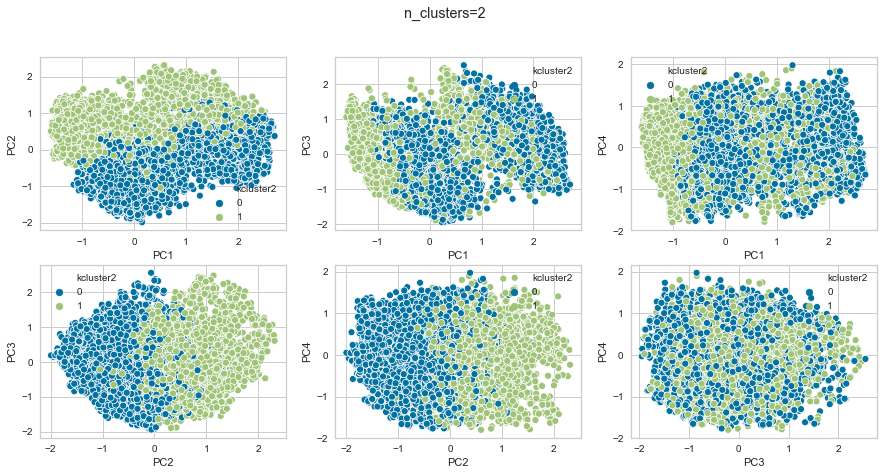

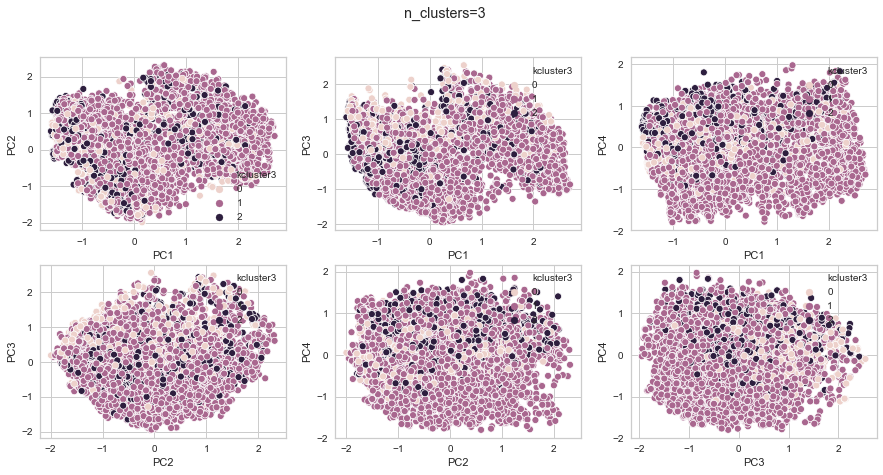

In [51]:
# LABEL_COLOR_MAP = {0 : 'red',
#                1 : 'blue',
#                2 : 'green',
#                3 : 'purple',
#                4 : 'violet',
#                5 : 'aqua'}

# axk =df.plot(
#     kind='scatter',
#     x='PC1',y='PC2',
#     c=df.cluster.map(LABEL_COLOR_MAP))

# for i, cluster in enumerate(df.index):
#     axk.annotate("", (df.iloc[i].PC1, df.iloc[i].PC2))

import matplotlib.pyplot as plt
import seaborn as sns; sns.color_palette("hls", 8);

fig, ax =plt.subplots(2,3,figsize=(15,7))
pc1_pc2 = sns.scatterplot(x="PC1", y="PC2", hue="kcluster2", data=df, ax=ax[0,0])
pc1_pc3 = sns.scatterplot(x="PC1", y="PC3", hue="kcluster2", data=df, ax=ax[0,1])
pc1_pc4 = sns.scatterplot(x="PC1", y="PC4", hue="kcluster2", data=df, ax=ax[0,2])
pc2_pc3 = sns.scatterplot(x="PC2", y="PC3", hue="kcluster2", data=df, ax=ax[1,0])
pc2_pc4 = sns.scatterplot(x="PC2", y="PC4", hue="kcluster2", data=df, ax=ax[1,1])
pc3_pc4 = sns.scatterplot(x="PC3", y="PC4", hue="kcluster2", data=df, ax=ax[1,2])
fig.suptitle("n_clusters=2")
plt.show()

fig, ax =plt.subplots(2,3,figsize=(15,7))
pc1_pc2 = sns.scatterplot(x="PC1", y="PC2", hue="kcluster3", data=df, ax=ax[0,0])
pc1_pc3 = sns.scatterplot(x="PC1", y="PC3", hue="kcluster3", data=df, ax=ax[0,1])
pc1_pc4 = sns.scatterplot(x="PC1", y="PC4", hue="kcluster3", data=df, ax=ax[0,2])
pc2_pc3 = sns.scatterplot(x="PC2", y="PC3", hue="kcluster3", data=df, ax=ax[1,0])
pc2_pc4 = sns.scatterplot(x="PC2", y="PC4", hue="kcluster3", data=df, ax=ax[1,1])
pc3_pc4 = sns.scatterplot(x="PC3", y="PC4", hue="kcluster3", data=df, ax=ax[1,2])
fig.suptitle("n_clusters=3")
plt.show()


Run Agglomeraitve Clustering...

In [57]:
%%time
import pickle
from sklearn.cluster import AgglomerativeClustering

c = sum(pca_sum <= 80)
print("Cluster on the first {0} features from the PCA Analysis".format(c))
X = X_pca[:,:c]

# clustering = AgglomerativeClustering().fit(X_pca)
clustering = AgglomerativeClustering(linkage="ward", n_clusters=2).fit(X)

# Save Model
filename = 'models/PCA_AgglomerativeClustering_k_eq_2.pkcl'
pickle.dump(clustering, open(filename, 'wb'))

Cluster on the first 24 features from the PCA Analysis
CPU times: user 1.42 s, sys: 100 ms, total: 1.52 s
Wall time: 1.52 s


In [61]:
df['Aggcluster2'] = clustering.labels_

Utilizing 10 PCA variables, plot the Agglomerative Clustering Catagories

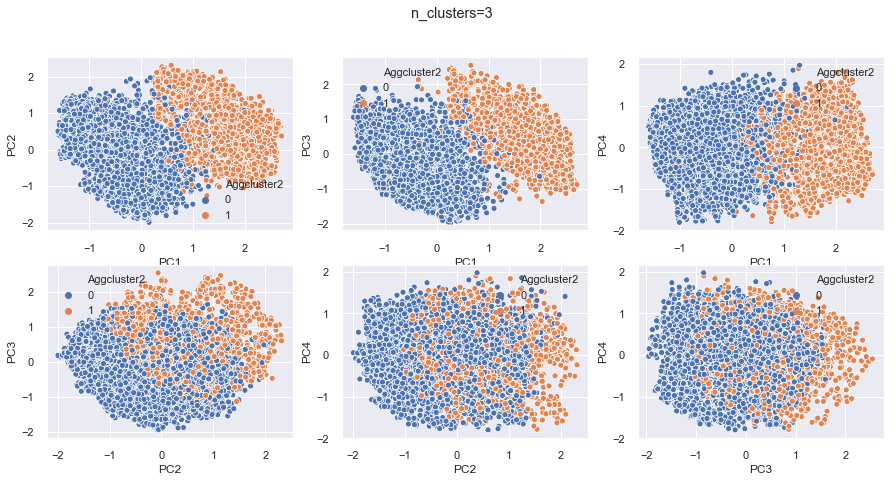

In [62]:
# Agg Cluster
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

fig, ax =plt.subplots(2,3,figsize=(15,7))
pc1_pc2 = sns.scatterplot(x="PC1", y="PC2", hue="Aggcluster2", data=df, ax=ax[0,0])
pc1_pc3 = sns.scatterplot(x="PC1", y="PC3", hue="Aggcluster2", data=df, ax=ax[0,1])
pc1_pc4 = sns.scatterplot(x="PC1", y="PC4", hue="Aggcluster2", data=df, ax=ax[0,2])
pc2_pc3 = sns.scatterplot(x="PC2", y="PC3", hue="Aggcluster2", data=df, ax=ax[1,0])
pc2_pc4 = sns.scatterplot(x="PC2", y="PC4", hue="Aggcluster2", data=df, ax=ax[1,1])
pc3_pc4 = sns.scatterplot(x="PC3", y="PC4", hue="Aggcluster2", data=df, ax=ax[1,2])
fig.suptitle("n_clusters=3")
plt.show()

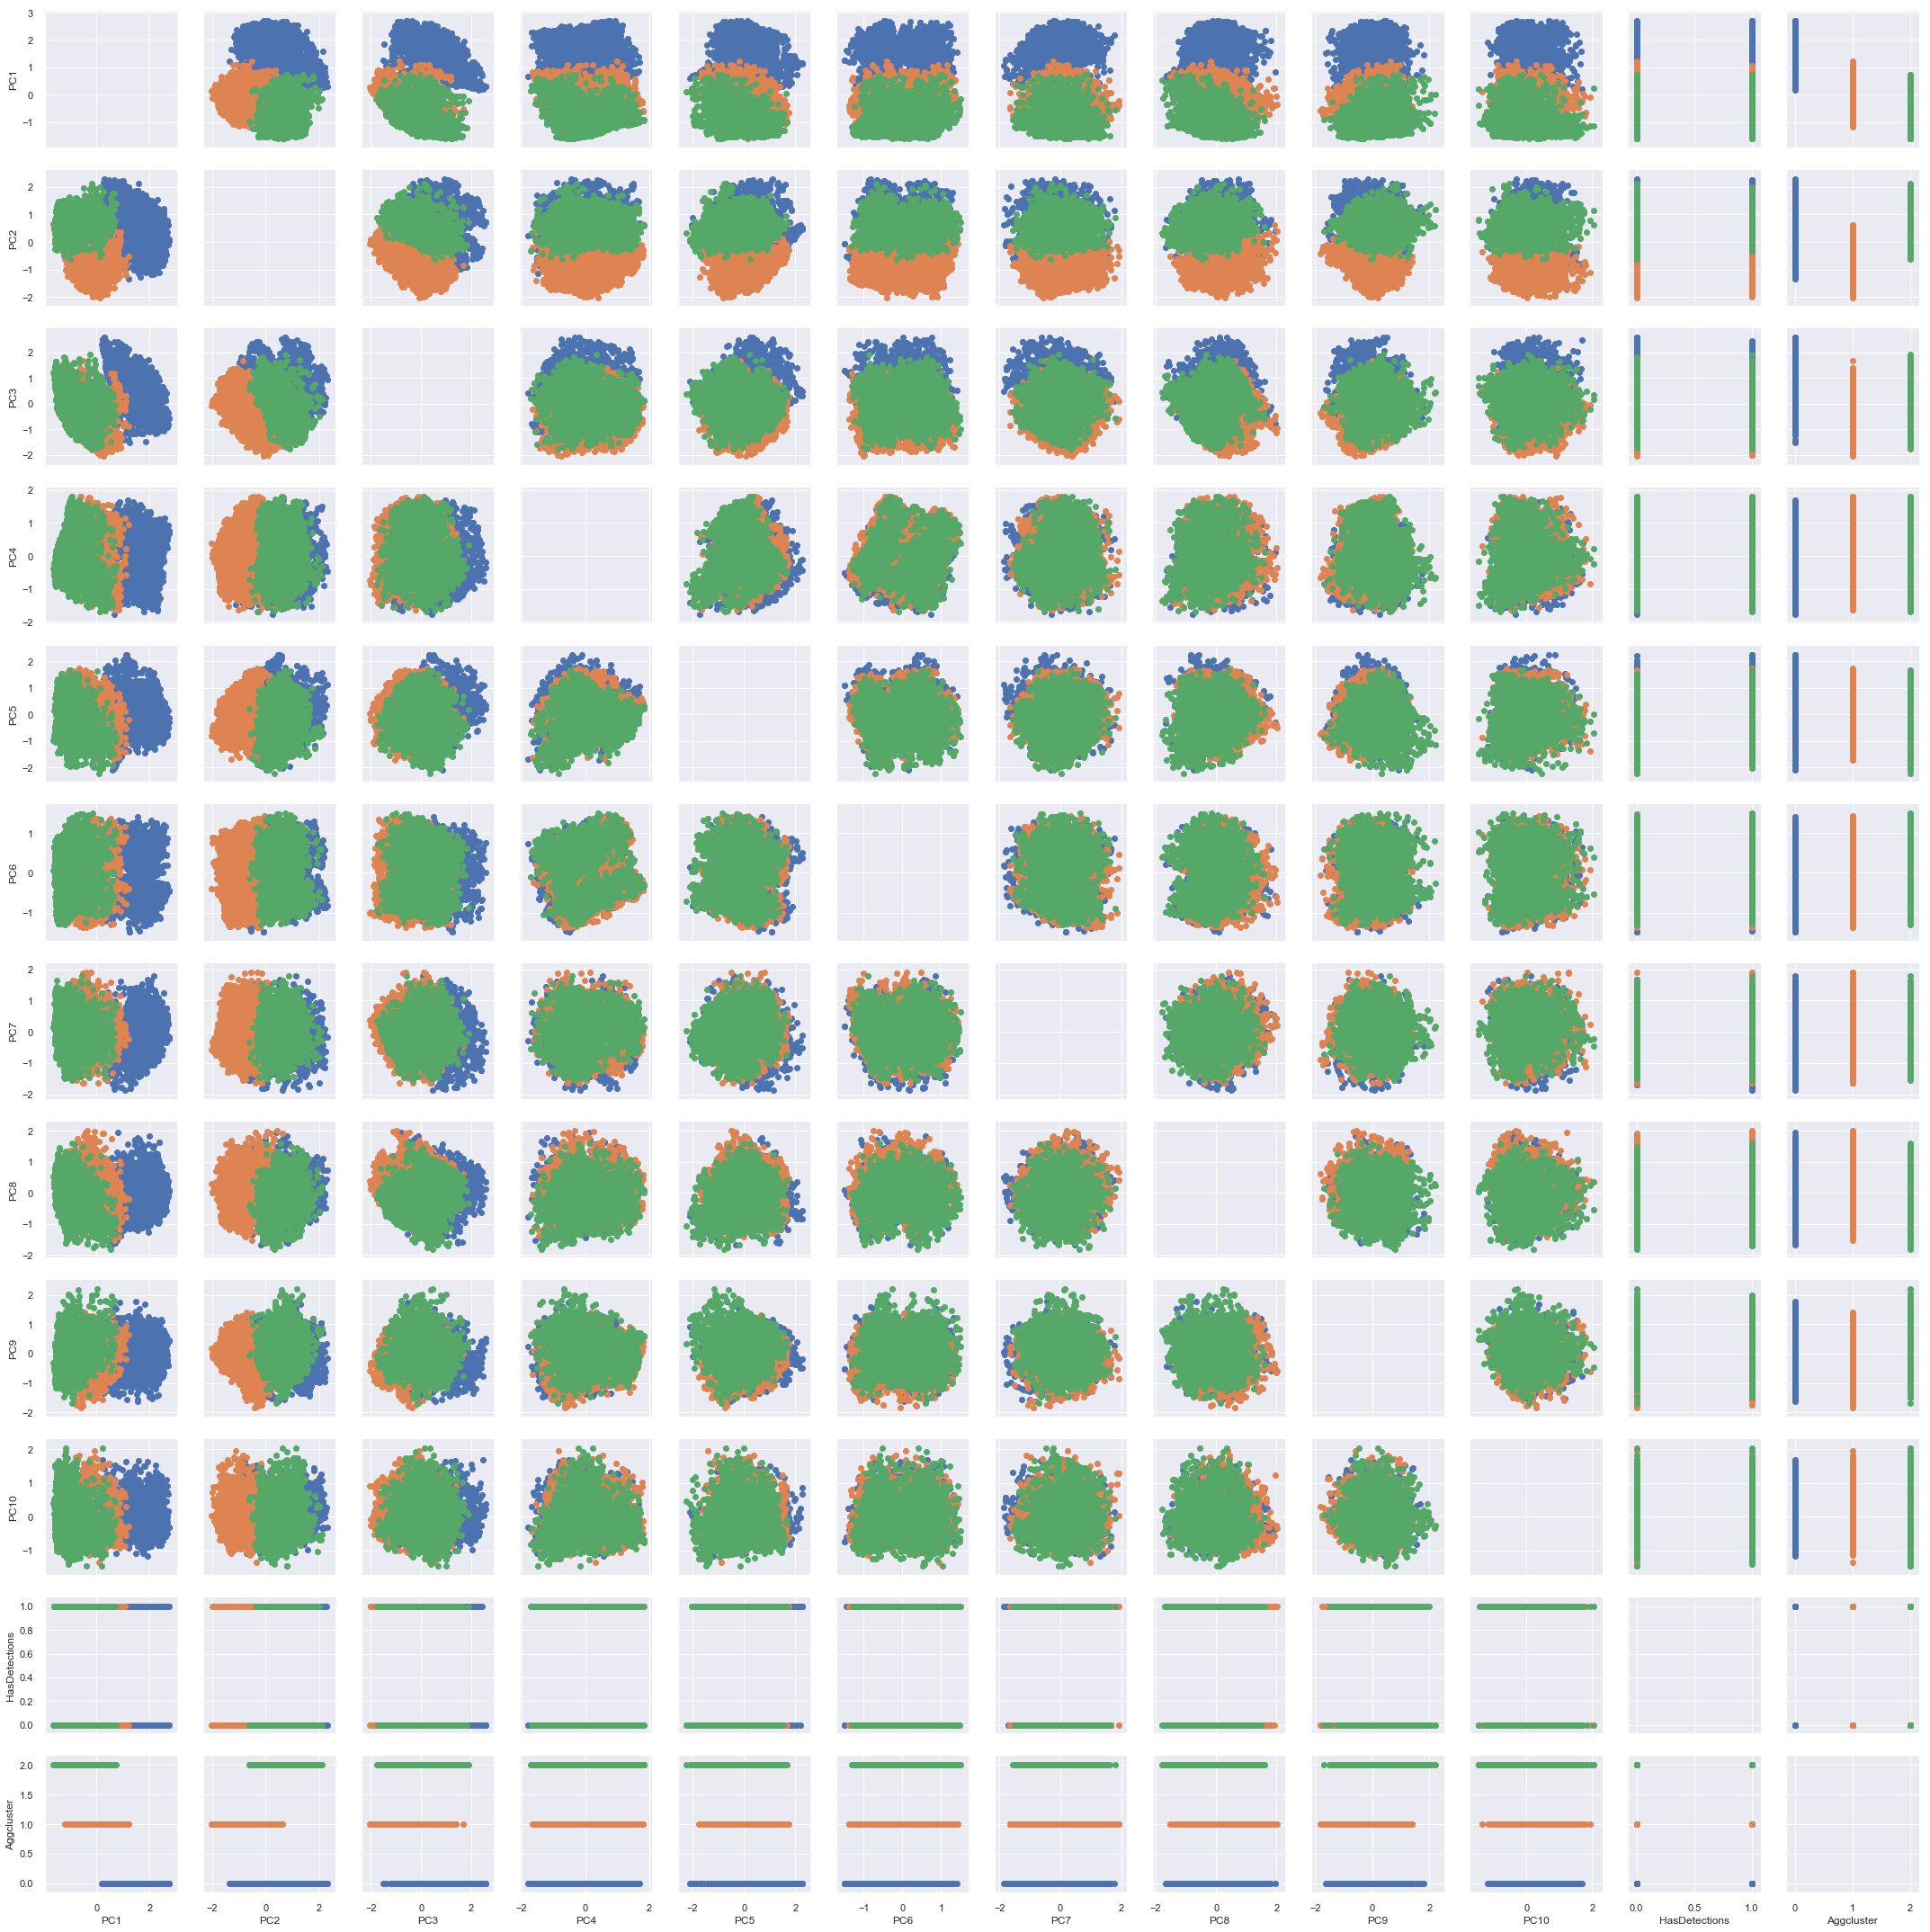

In [17]:
df = pd.DataFrame(X_pca[:,:10])
df.columns = ['PC1','PC2', 'PC3', 'PC4','PC5', 'PC6','PC7', 'PC8','PC9','PC10']
df['HasDetections'] = HasDetections_response_data.values
df['Aggcluster'] = cluster_labels

# Not working
g = sns.PairGrid(df,hue="Aggcluster")
g = g.map_offdiag(plt.scatter)
# g = g.map_diag(plt.hist)

Using the Agglomerative above, build a dendrogram plot for the Ward, Complete, Average, and Single Linkage

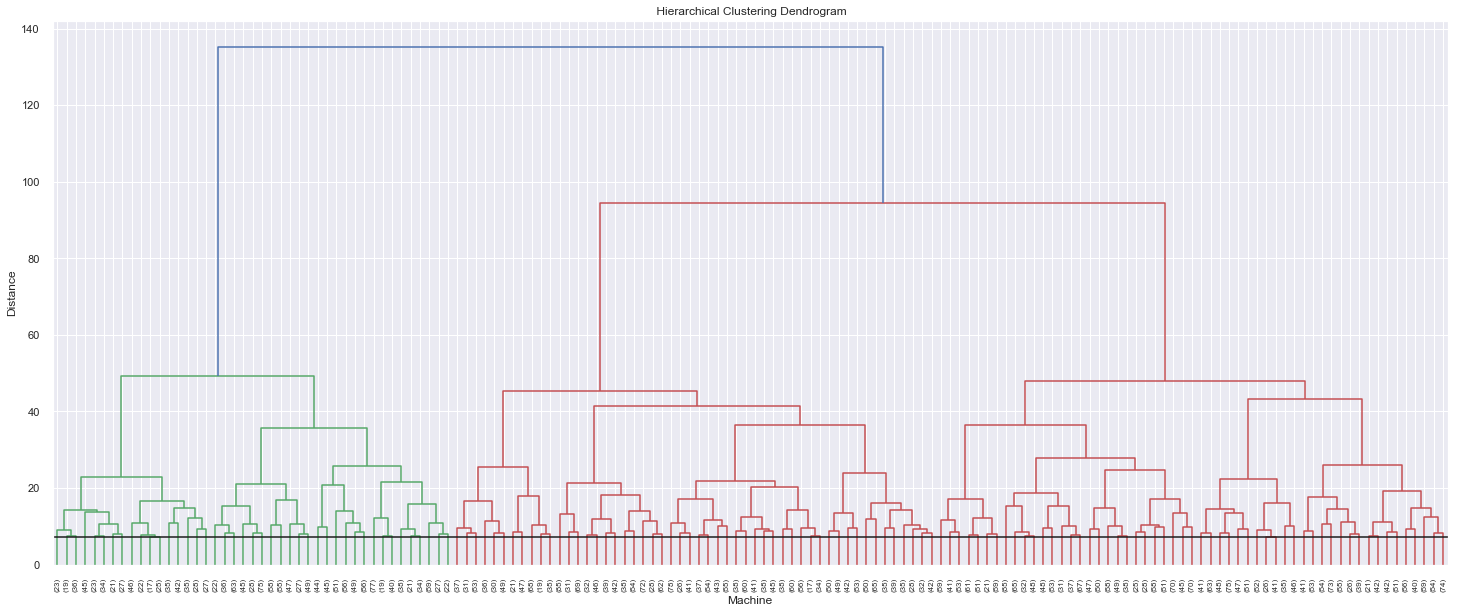

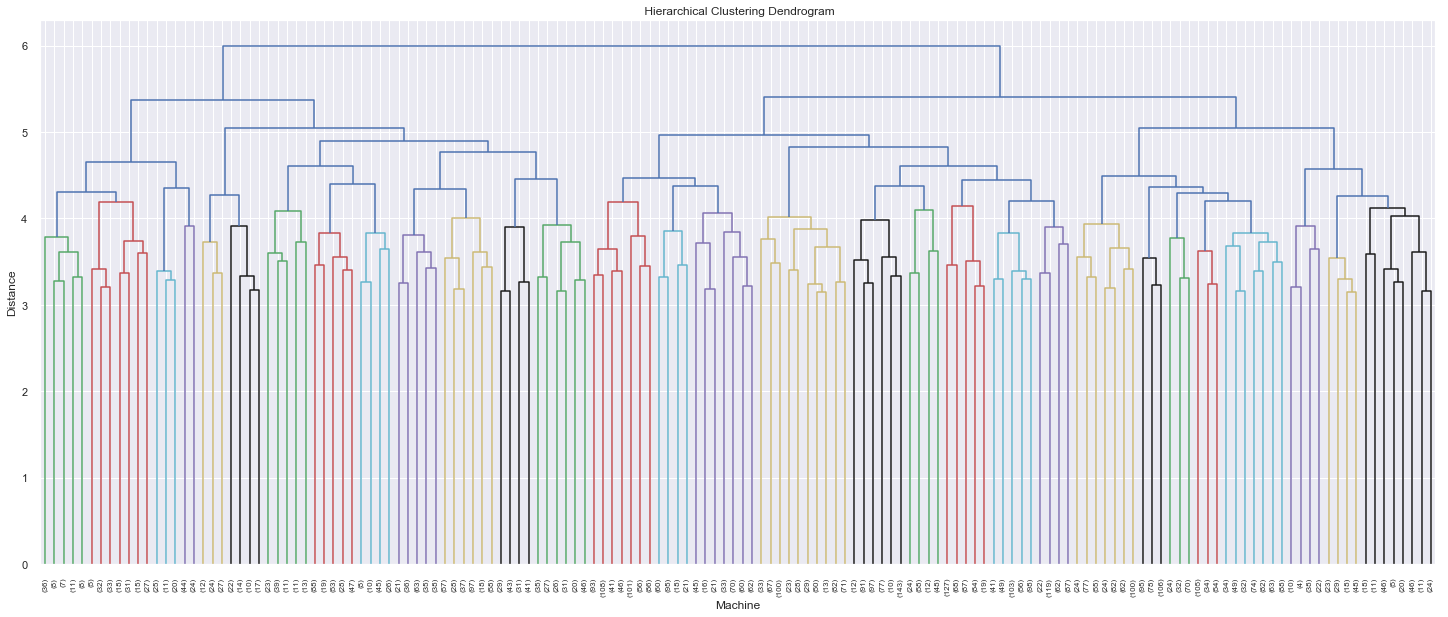

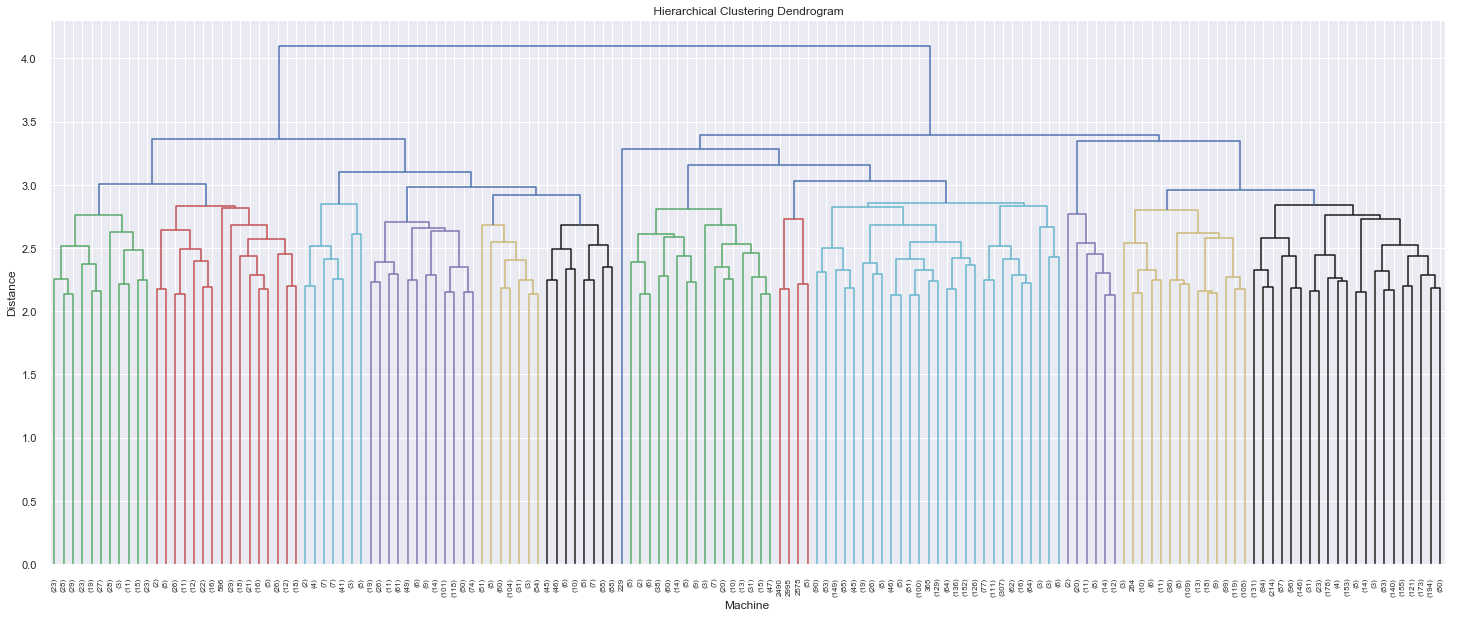

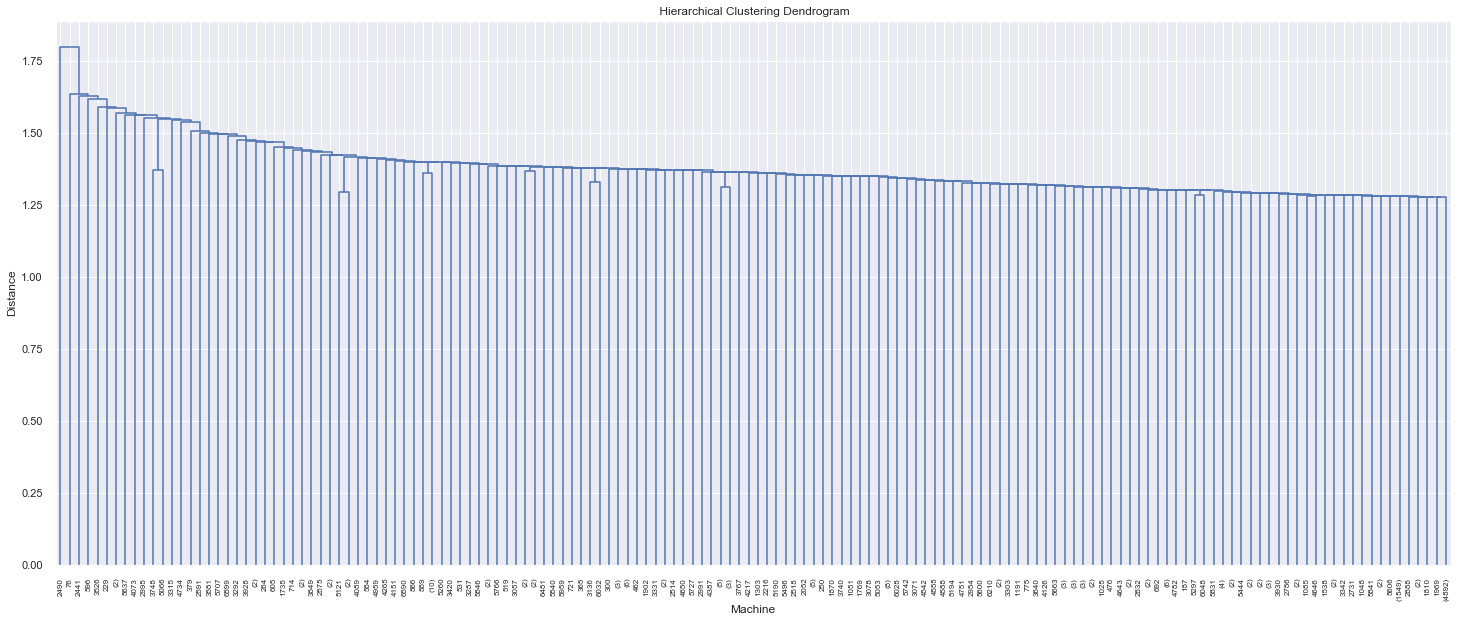

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage
link = ['ward', 'complete', 'average', 'single']


for a in link:
    Z = linkage(df, a)

    # set cut-off to 150
    max_d = 7.08                # max_d as in max_distance

    plt.figure(figsize=(25, 10))
    plt.title(' Hierarchical Clustering Dendrogram')
    plt.xlabel('Machine')
    plt.ylabel('Distance')
    dendrogram(
        Z,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=150,                  # Try changing values of p
        leaf_rotation=90.,      # rotates the x axis labels
        leaf_font_size=8.,      # font size for the x axis labels
    )
    plt.axhline(y=max_d, c='k')
    plt.show()

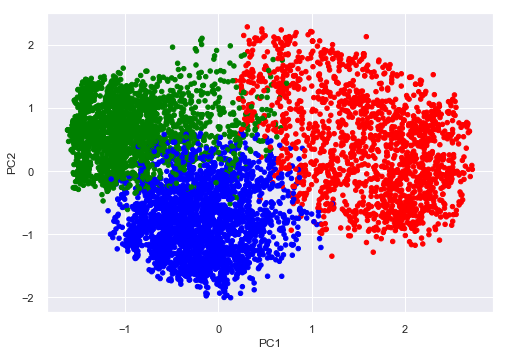

In [19]:
agg =df.plot(
    kind='scatter',
    x='PC1',y='PC2',
    c=df.Aggcluster.map(LABEL_COLOR_MAP))

for i, index in enumerate(df.index):
    agg.annotate("", (df.iloc[i].PC1, df.iloc[i].PC2))

Consolidate the KMeans, Agglomerative, and Originazl Model Dataset into one overall dataframe

In [20]:
# Consolidate DataFrames
result = pd.merge(df, HasDetections_model_data, left_index=True, right_index=True)


Compare the differences between the KMeans and Agglomerative and describe the new field "Cluster_minus_Agg"

In [21]:
result['Cluster_minus_Agg'] = result['cluster']== result['Aggcluster']
result.Cluster_minus_Agg.describe()

count       133
unique        2
top       False
freq         78
Name: Cluster_minus_Agg, dtype: object

Split the KMeans and Agglomerative by each cluster to conduct futher Modeling and Feature Importance

In [22]:
Aggcluster0 = pd.DataFrame(result.loc[result['Aggcluster'] == 0])
Aggcluster1 = pd.DataFrame(result.loc[result['Aggcluster'] == 1])
Aggcluster2 = pd.DataFrame(result.loc[result['Aggcluster'] == 2])

cluster0 = pd.DataFrame(result.loc[result['cluster'] == 0])
cluster1 = pd.DataFrame(result.loc[result['cluster'] == 1])
cluster2 = pd.DataFrame(result.loc[result['cluster'] == 2])

print("Cluster 0", cluster0.shape)
print("Cluster 1", cluster1.shape)
print("Cluster 2", cluster2.shape)
print("AggCluster 0", Aggcluster0.shape)
print("AggCluster 1", Aggcluster1.shape)
print("AggCluster 2", Aggcluster2.shape)


Cluster 0 (34, 241)
Cluster 1 (47, 241)
Cluster 2 (52, 241)
AggCluster 0 (31, 241)
AggCluster 1 (54, 241)
AggCluster 2 (48, 241)


In [23]:
# # from sklearn.feature_selection import SelectKBest, chi2

# X = cluster0.loc[:, cluster0.columns != 'HasDetections'].values
# y = cluster0["HasDetections"]

# bestfeatures = SelectKBest(chi2, k=5)
# fit = bestfeatures.fit(X, y)

# # dfscores = pd.DataFrame(fit.scores_)
# # dfcolumns = pd.DataFrame(cluster1.columns)


# # featureScores0 = pd.concat([dfcolumns,dfscores],axis=1)
# # featureScores0.columns = ['Feature','Cluster_0'] #naming the dataframe columns
# # # print(featureScores0.nlargest(5,'Cluster_0', )) #print best features

In [24]:
# X = cluster1.loc[:, cluster1.columns != 'HasDetections'].values
# y = cluster1["HasDetections"]


# from sklearn.feature_selection import SelectKBest, chi2
# bestfeatures = SelectKBest(chi2, k=5)
# fit = bestfeatures.fit(X, y)

# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(cluster2.columns)


# featureScores1 = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores1.columns = ['Feature','Cluster_1'] #naming the dataframe columns
# # print(featureScores1.nlargest(5,'Cluster_1')) #print best features

In [25]:
# X = cluster2.loc[:, cluster2.columns != 'HasDetections'].values
# y = cluster2["HasDetections"]


# from sklearn.feature_selection import SelectKBest, chi2
# bestfeatures = SelectKBest(chi2, k=5)
# fit = bestfeatures.fit(X, y)

# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(cluster2.columns)


# featureScores2 = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores2.columns = ['Feature','Cluster_2'] #naming the dataframe columns
# # print(featureScores2.nlargest(5,'Cluster_2')) #print best features

Agg Cluster

In [ ]:
# X = AggCluster0.loc[:, AggCluster0.columns != 'HasDetections'].values
# y = AggCluster0["HasDetections"]


# from sklearn.feature_selection import SelectKBest, chi2
# bestfeatures = SelectKBest(chi2, k=5)
# fit = bestfeatures.fit(X, y)

# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(AggCluster1.columns)


# featureScores3 = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores3.columns = ['Feature','AggCluster_0'] #naming the dataframe columns
# # print(featureScores0.nlargest(5,'AggCluster_0', )) #print best features

In [ ]:
# X = AggCluster1.loc[:, AggCluster1.columns != 'HasDetections'].values
# y = AggCluster1["HasDetections"]


# from sklearn.feature_selection import SelectKBest, chi2
# bestfeatures = SelectKBest(chi2, k=5)
# fit = bestfeatures.fit(X, y)

# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(AggCluster2.columns)


# featureScores4 = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores4.columns = ['Feature','AggCluster_1'] #naming the dataframe columns
# # print(featureScores1.nlargest(5,'AggCluster_1')) #print best features

In [ ]:
# X = AggCluster2.loc[:, AggCluster2.columns != 'HasDetections'].values
# y = AggCluster2["HasDetections"]


# from sklearn.feature_selection import SelectKBest, chi2
# bestfeatures = SelectKBest(chi2, k=5)
# fit = bestfeatures.fit(X, y)

# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(AggCluster2.columns)


# featureScores5 = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores5.columns = ['Feature','AggCluster_2'] #naming the dataframe columns
# # print(featureScores2.nlargest(5,'AggCluster_2')) #print best features

Join Features Importance

In [ ]:
# featureImportance = featureScores0.join(featureScores1.set_index('Feature'), on='Feature')
# featureImportance = featureImportance.join(featureScores2.set_index('Feature'), on='Feature')
# featureImportance = featureImportance.join(featureScores3.set_index('Feature'), on='Feature')
# featureImportance = featureImportance.join(featureScores4.set_index('Feature'), on='Feature')
# featureImportance = featureImportance.join(featureScores5.set_index('Feature'), on='Feature')
# # featureImportance.dropna(inplace=True)
# featureImportance


Begin Random Forest 

In [29]:
value = 10
print('Valueis' + str(value) + '')


Valueis10


In [60]:
Aggcluster1.HasDetections.describe()


count    54.000000
mean      0.425926
std       0.499126
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: HasDetections, dtype: float64

In [91]:
# Run Test Model
RunRFModel(Aggcluster1, 'Agg01')



[[-0.8843911920104419 -1.1583111025650012 0.9063281302385755 ... 0 0
  False]
 [-0.2137978233566365 -0.8432815391769357 -0.7421290752057793 ... 0 2
  False]
 [-0.31198512654907806 -0.8846623152857251 0.5404539391156744 ... 0 1
  True]
 ...
 [-0.2994030592903315 -1.11308943466351 0.6200334348502499 ... 0 2 False]
 [-0.16445361872894979 -0.10633088714043257 -1.789225568340623 ... 0 1
  True]
 [-0.04172057977088078 -1.4973393063254934 0.10181232999423134 ... 0 2
  False]]
Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done 204 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-2)]: Done 360 out of 360 | elapsed:    5.2s finished
/Users/gbourzik/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [90]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import pickle


def RunRFModel(df, name):
    X = df.loc[:, df.columns != 'HasDetections'].values
    y = df["HasDetections"]
    print(X)

    #   Createth Cross Validation Objected used for all tests
    num_cv_iterations = 10
    random_st = 42
    kfold_cv = KFold(
        n_splits=num_cv_iterations,
        random_state = random_st
    )
    
    clf = RandomForestClassifier(random_state=42)
    
    grid_params = [{
        "max_features" : ["auto","log2",0.20, 0.30],
        "n_estimators" : [10,20,50],
        "min_samples_leaf" : [5, 20, 50]
    }]
    
    scoring = {
        'acc':'accuracy',
        'precision':'precision',
        'recall':'recall',
        'auc':'roc_auc',
        'mse':'neg_mean_squared_error',
        'r2':'r2'
    }
    
    grid_clf = GridSearchCV(
        estimator = clf, 
        param_grid=grid_params, 
        cv=kfold_cv, 
#         scoring=scoring,
#         refit='auc',
        n_jobs=-2,verbose=1,return_train_score=False)
    
    grid_clf.fit(X, y)

    # # Save Model
    filename = ('models/HasDetections_GridSearch_RF_' + str(name) + '')
    pickle.dump(grid_clf, open(filename, 'wb'))

CPU times: user 21 µs, sys: 0 ns, total: 21 µs
Wall time: 24.8 µs


# Chris Random Forest Model

In [86]:
%%time
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Add Clusters
X = model_data.values
y = response_data.values

# Creat eth Cross Validation Objected used for all tests
num_cv_iterations = 10
random_st = 42
kfold_cv = KFold(
    n_splits=num_cv_iterations,
    random_state = random_st
)

clf = RandomForestClassifier(random_state=42)

grid_params = [{
    "max_features" : ["auto","log2",0.20, 0.30],
    "n_estimators" : [10,50,100],
    "min_samples_leaf" : [25, 50, 100]
}]

scoring = {
    'acc':'accuracy',
    'precision':'precision',
    'recall':'recall',
    'auc':'roc_auc',
    'mse':'neg_mean_squared_error',
    'r2':'r2'
}

grid_clf = GridSearchCV(
    estimator = clf, 
    param_grid=grid_params, 
    cv=kfold_cv, 
    scoring=scoring,
    refit='auc',
    n_jobs=-2,verbose=1,return_train_score=False)

rows = len(response_data)
predictions = pd.DataFrame(
    {
        'cluster':np.zeros(rows),
        'y':response_data,
        'yhat':np.zeros(rows),
        'yhat_score':np.zeros(rows)
    }
)

for k in [0,1,2]:
    idx = np.where(cluster3 == k)[0]
    
    # Get the optimal parameters
    grid_clf.fit(X[idx],y[idx])
    
    # Save Model
    filename = 'models/HasDetections_Cluster_GridSearch_RF_k_eq_{0}.sav'.format(k)
    pickle.dump(grid_clf, open(filename, 'wb'))
    
    clf = grid_clf.best_estimator_
    
    # Get yhat estimates
    for train, test in kfold_cv.split(X[idx],y[idx]):
        clf.fit(X[train],y[train])
        predictions.loc[test,'cluster'] = k
        predictions.loc[test,'rf_yhat'] = rf_clf.predict(X[test])
        predictions.loc[test, 'rf_yhat_score'] = rf_clf.predict_proba(X[test])[:,1]


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 360 out of 360 | elapsed:    5.0s finished


KeyError: "None of [Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,\n            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,\n            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,\n            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,\n            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82],\n           dtype='int64')] are in the [index]"

In [90]:
idx = np.where(cluster3 == k)[0]
idx

array([   7,   17,   26, ..., 6633, 6636, 6644])

In [91]:
model_data.head(10)

Census_IsSecureBootEnabled  Wdft_IsGamer  Census_ProcessorCoreCount  \
121958                           0           0.0                        2.0   
146867                           1           1.0                        2.0   
131932                           1           0.0                        2.0   
259178                           1           0.0                        4.0   
119879                           1           0.0                        4.0   
110268                           0           1.0                        4.0   
207892                           0           0.0                        2.0   
54886                            1           1.0                        4.0   
137337                           1           0.0                        4.0   
87498                            1           1.0                        2.0   

        Census_PrimaryDiskTotalCapacity  Census_TotalPhysicalRAM  \
121958                        13.075146                 8.317766   
146867                        13.075146                 8.317766   
131932                        13.768282                 9.010913   
259178                        13.768282                 9.010913   
119879                        13.075146                 8.317766   
110268                        10.295530                 6.931472   
207892                        13.075146                 8.030084   
54886                         13.075146                 8.317766   
137337                        13.768282                 8.723231   
87498                         13.768282                 8.317766   

        Census_InternalPrimaryDiagonalDisplaySizeInInches  \
121958                                               14.0   
146867                                               13.9   
131932                                               13.9   
259178                                               23.0   
119879                                               13.9   
110268                                                8.8   
207892                                               18.9   
54886                                                15.5   
137337                                               13.9   
87498                                                11.4   

        Census_InternalBatteryNumberOfCharges  TotalDisplayResolution  \
121958                           0.000000e+00               1049088.0   
146867                           0.000000e+00               1049088.0   
131932                           0.000000e+00               1049088.0   
259178                           4.294967e+09               2073600.0   
119879                           3.200000e+01               1049088.0   
110268                           1.590000e+02               1024000.0   
207892                           4.294967e+09                786432.0   
54886                            0.000000e+00               1049088.0   
137337                           6.400000e+01               1049088.0   
87498                            0.000000e+00                786432.0   

        EngineVersion_1.1.11701.0  EngineVersion_1.1.11903.0  ...  \
121958                          0                          0  ...   
146867                          0                          0  ...   
131932                          0                          0  ...   
259178                          0                          0  ...   
119879                          0                          0  ...   
110268                          0                          0  ...   
207892                          0                          0  ...   
54886                           0                          0  ...   
137337                          0                          0  ...   
87498                           0                          0  ...   

        Census_OSWUAutoUpdateOptionsName_DownloadNotify  \
121958                                                0   
146867                             